# Add Latest Data
* This notebook will enable a quick and easy method to gather and update Ethereum and Bitcoin 1-minute price data so that the database remains relevant and includes the latest information

## General-Purpose Code 
* This code is used for any and all cryptocurrencies updated in this notebook, so it is placed at the beginning and not under one of the coin-specific sections

In [15]:
import pandas as pd
from sqlalchemy import create_engine
import config
import coinbase_data_pull as c_pull
import time
import datetime as dt
import requests

In [4]:
#create the string to connect to the database - will be used with sqlalchemy!
protocol = "postgresql"
user = config.user
password = config.pw
location = "localhost"
port = "5432"
database = "crypto"

connection_string = f"{protocol}://{user}:{password}@{location}:{port}/{database}"

In [5]:
#Use SQLAlchemy to connect to the database

#create the engine to interact with the database with the connection string
engine = create_engine(connection_string)

## Ethereum

### Import and Verify Data

In [ ]:
# load in Ethereum csv file for the notebook, to be changed and then used to update itself and the 'ethereum' SQL table
eth_csv = './Ethereum/IO/ETH_1min.csv'

eth_df = pd.read_csv(eth_csv)

#convert the "Date" column to datetime objects with timezones, because it is read in as text
eth_df["Date"] = pd.to_datetime(eth_df["Date"], utc=True)
eth_df

In [ ]:
#update the column names to match the schema of the database table
sql_columns = ["Unix_Timestamp", "Entry_Date", "Symbol", "Open_Price", "High_Price", "Low_Price", "Close_Price", "Coin_Volume"]
lowercase_sql_columns = [a.lower() for a in sql_columns]
eth_df.columns = lowercase_sql_columns
eth_df

In [ ]:
#verify that the .csv and database table match - so pull the sql table!

eth_db_df = pd.read_sql_table(table_name="ethereum", con=engine)
eth_db_df

In [ ]:
#check that tables are the same!
#this process may be accelerated in the future - e.g. only check latest 100000 rows?

#first, sort and reindex the tables in case any rows got mixed up

sorted_eth_db_df = eth_db_df.sort_values(by="unix_timestamp").reset_index(drop=True)
sorted_eth_df = eth_df.sort_values(by="unix_timestamp").reset_index(drop=True)

#ran into a precision error - probably due to floating point numbers
#worked when testing.assert_frame_equal did not have 'check_exact' set to True

#if no error is thrown, proceed!
#otherwise, check the output!
try:
    pd.testing.assert_frame_equal(sorted_eth_df, sorted_eth_db_df)
    print("Congratulations! The tables match - there are no differences between the .csv and your 'ethereum' table!")
except:
    print("It looks like the .csv file does not match the data read from the database.")

### Retrieve Additional Data

In [ ]:
#change column names back so that the functions can work
sorted_eth_df.columns = ["Unix Timestamp", "Date", "Symbol", "Open", "High", "Low", "Close", "Volume"]
sorted_eth_df

In [ ]:
#if the data is verified, then start to pull data using the API

results = c_pull.get_current_data(sorted_eth_df)
unclean_api_df = c_pull.convert_results_to_df(results)
clean_update_df = c_pull.clean_results_df(unclean_api_df, sorted_eth_df)

#resulting cleaned, updated dataframe
clean_update_df

### Update SQL Database

In [ ]:
#Make a copy of the update with the correct column names for the SQL table
eth_sql_update = clean_update_df.copy()
eth_sql_update.columns = [a.lower() for a in ["Unix_Timestamp", "Low_Price", "High_Price", "Open_Price",
                          "Close_Price", "Coin_Volume", "Entry_Date",  "Symbol"]]
eth_sql_update

In [ ]:
#now append data to SQL database
eth_sql_update.to_sql(name="ethereum", con=engine, index=False, if_exists="append")
print("If you can see this, the table should have loaded successfully!")

### Update CSV

In [ ]:
output_csv_df = sorted_eth_df.append(clean_update_df)
output_csv_df

In [ ]:
output_csv_df.plot(x="Date", y="Close")

In [ ]:
#output final_df to csv
output_csv_df.to_csv("./Ethereum/IO/ETH_1min.csv", index=False)
print("1-minute Ethereum csv file output!")

## Bitcoin

### Import and Verify Data

In [6]:
# load in Bitcoin csv file for the notebook, to be changed and then used to update itself and the 'bitcoin' SQL table
btc_csv = './Bitcoin/IO/coinbaseUSD_1-min_data.csv'

btc_df = pd.read_csv(btc_csv)

#convert the "Date" column to datetime objects with timezones, because it is read in as text
btc_df["Date"] = pd.to_datetime(btc_df["Date"], utc=True)
btc_df

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1417411980,2014-12-01 05:33:00+00:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
1,1417412400,2014-12-01 05:40:00+00:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
2,1417415040,2014-12-01 06:24:00+00:00,BTC-USD,370.00,370.00,370.00,370.00,0.010000
3,1417416600,2014-12-01 06:50:00+00:00,BTC-USD,370.00,370.00,370.00,370.00,0.026556
4,1417498140,2014-12-02 05:29:00+00:00,BTC-USD,377.00,377.00,377.00,377.00,0.010000
...,...,...,...,...,...,...,...,...
4295656,1685301360,2023-05-28 19:16:00+00:00,BTC-USD,27612.48,27615.53,27602.88,27603.61,1.763234
4295657,1685301420,2023-05-28 19:17:00+00:00,BTC-USD,27604.38,27607.15,27601.89,27602.89,1.807769
4295658,1685301480,2023-05-28 19:18:00+00:00,BTC-USD,27602.86,27602.86,27582.60,27584.94,7.486131
4295659,1685301540,2023-05-28 19:19:00+00:00,BTC-USD,27583.23,27604.69,27582.59,27602.31,3.189308


In [7]:
#update the column names to match the schema of the database table
sql_columns = ["Unix_Timestamp", "Entry_Date", "Symbol", "Open_Price", "High_Price", "Low_Price", "Close_Price", "Coin_Volume"]
lowercase_sql_columns = [a.lower() for a in sql_columns]
btc_df.columns = lowercase_sql_columns
btc_df

,unix_timestamp,entry_date,symbol,open_price,high_price,low_price,close_price,coin_volume
0,1417411980,2014-12-01 05:33:00+00:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
1,1417412400,2014-12-01 05:40:00+00:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
2,1417415040,2014-12-01 06:24:00+00:00,BTC-USD,370.00,370.00,370.00,370.00,0.010000
3,1417416600,2014-12-01 06:50:00+00:00,BTC-USD,370.00,370.00,370.00,370.00,0.026556
4,1417498140,2014-12-02 05:29:00+00:00,BTC-USD,377.00,377.00,377.00,377.00,0.010000
...,...,...,...,...,...,...,...,...
4295656,1685301360,2023-05-28 19:16:00+00:00,BTC-USD,27612.48,27615.53,27602.88,27603.61,1.763234
4295657,1685301420,2023-05-28 19:17:00+00:00,BTC-USD,27604.38,27607.15,27601.89,27602.89,1.807769
4295658,1685301480,2023-05-28 19:18:00+00:00,BTC-USD,27602.86,27602.86,27582.60,27584.94,7.486131
4295659,1685301540,2023-05-28 19:19:00+00:00,BTC-USD,27583.23,27604.69,27582.59,27602.31,3.189308


In [8]:
#verify that the .csv and database table match - so pull the sql table!

btc_db_df = pd.read_sql_table(table_name="bitcoin", con=engine)
btc_db_df

,unix_timestamp,entry_date,symbol,open_price,high_price,low_price,close_price,coin_volume
0,1417411980,2014-12-01 05:33:00+00:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
1,1417412400,2014-12-01 05:40:00+00:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
2,1417415040,2014-12-01 06:24:00+00:00,BTC-USD,370.00,370.00,370.00,370.00,0.010000
3,1417416600,2014-12-01 06:50:00+00:00,BTC-USD,370.00,370.00,370.00,370.00,0.026556
4,1417498140,2014-12-02 05:29:00+00:00,BTC-USD,377.00,377.00,377.00,377.00,0.010000
...,...,...,...,...,...,...,...,...
4295656,1685301360,2023-05-28 19:16:00+00:00,BTC-USD,27612.48,27615.53,27602.88,27603.61,1.763234
4295657,1685301420,2023-05-28 19:17:00+00:00,BTC-USD,27604.38,27607.15,27601.89,27602.89,1.807769
4295658,1685301480,2023-05-28 19:18:00+00:00,BTC-USD,27602.86,27602.86,27582.60,27584.94,7.486131
4295659,1685301540,2023-05-28 19:19:00+00:00,BTC-USD,27583.23,27604.69,27582.59,27602.31,3.189308


In [9]:
#check that tables are the same!
#this process may be accelerated in the future - e.g. only check latest 100000 rows?

#first, sort and reindex the tables in case any rows got mixed up

sorted_btc_db_df = btc_db_df.sort_values(by="unix_timestamp").reset_index(drop=True)
sorted_btc_df = btc_df.sort_values(by="unix_timestamp").reset_index(drop=True)

#ran into a precision error - probably due to floating point numbers
#worked when testing.assert_frame_equal did not have 'check_exact' set to True

#if no error is thrown, proceed!
#otherwise, check the output!
try:
    pd.testing.assert_frame_equal(sorted_btc_df, sorted_btc_db_df)
    print("Congratulations! The tables match - there are no differences between the .csv and your 'bitcoin' table!")
except:
    print("It looks like the .csv file does not match the data read from the database.")

Congratulations! The tables match - there are no differences between the .csv and your 'bitcoin' table!


### Retrieve Additional Data

In [10]:
#change column names back so that the functions can work
sorted_btc_df.columns = ["Unix Timestamp", "Date", "Symbol", "Open", "High", "Low", "Close", "Volume"]
sorted_btc_df

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1417411980,2014-12-01 05:33:00+00:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
1,1417412400,2014-12-01 05:40:00+00:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
2,1417415040,2014-12-01 06:24:00+00:00,BTC-USD,370.00,370.00,370.00,370.00,0.010000
3,1417416600,2014-12-01 06:50:00+00:00,BTC-USD,370.00,370.00,370.00,370.00,0.026556
4,1417498140,2014-12-02 05:29:00+00:00,BTC-USD,377.00,377.00,377.00,377.00,0.010000
...,...,...,...,...,...,...,...,...
4295656,1685301360,2023-05-28 19:16:00+00:00,BTC-USD,27612.48,27615.53,27602.88,27603.61,1.763234
4295657,1685301420,2023-05-28 19:17:00+00:00,BTC-USD,27604.38,27607.15,27601.89,27602.89,1.807769
4295658,1685301480,2023-05-28 19:18:00+00:00,BTC-USD,27602.86,27602.86,27582.60,27584.94,7.486131
4295659,1685301540,2023-05-28 19:19:00+00:00,BTC-USD,27583.23,27604.69,27582.59,27602.31,3.189308


In [17]:
from importlib import reload
reload(c_pull)

#if the data is verified, then start to pull data using the API

results = c_pull.get_current_data(sorted_btc_df)
unclean_api_df = c_pull.convert_results_to_df(results)
clean_update_df = c_pull.clean_results_df(unclean_api_df, sorted_btc_df)

#resulting cleaned, updated dataframe
clean_update_df

2023-05-28T19:20:00+00:00
2023-05-29T00:19:00+00:00
2023-05-29T05:18:00+00:00
2023-05-29T10:17:00+00:00
2023-05-29T15:16:00+00:00
2023-05-29T20:15:00+00:00
2023-05-30T01:14:00+00:00
2023-05-30T06:13:00+00:00
2023-05-30T11:12:00+00:00
2023-05-30T16:11:00+00:00
2023-05-30T21:10:00+00:00
2023-05-31T02:09:00+00:00
2023-05-31T07:08:00+00:00
2023-05-31T12:07:00+00:00
2023-05-31T17:06:00+00:00
2023-05-31T22:05:00+00:00
2023-06-01T03:04:00+00:00
2023-06-01T08:03:00+00:00
2023-06-01T13:02:00+00:00
2023-06-01T18:01:00+00:00
2023-06-01T23:00:00+00:00
2023-06-02T03:59:00+00:00
2023-06-02T08:58:00+00:00
2023-06-02T13:57:00+00:00
2023-06-02T18:56:00+00:00
2023-06-02T23:55:00+00:00
2023-06-03T04:54:00+00:00
2023-06-03T09:53:00+00:00
2023-06-03T14:52:00+00:00
2023-06-03T19:51:00+00:00
2023-06-04T00:50:00+00:00
2023-06-04T05:49:00+00:00
2023-06-04T10:48:00+00:00
2023-06-04T15:47:00+00:00
2023-06-04T20:46:00+00:00
2023-06-05T01:45:00+00:00
2023-06-05T06:44:00+00:00
2023-06-05T11:43:00+00:00
2023-06-05T1

,Unix Timestamp,Low,High,Open,Close,Volume,Date,Symbol
1,1685301660,27610.94,27619.37,27619.10,27612.60,2.089523,2023-05-28 19:21:00+00:00,BTC-USD
2,1685301720,27612.29,27639.95,27614.71,27627.96,12.918422,2023-05-28 19:22:00+00:00,BTC-USD
3,1685301780,27621.67,27631.94,27629.83,27626.45,0.901151,2023-05-28 19:23:00+00:00,BTC-USD
4,1685301840,27618.30,27634.25,27626.45,27625.93,2.864373,2023-05-28 19:24:00+00:00,BTC-USD
5,1685301900,27615.59,27628.99,27628.99,27621.99,3.208836,2023-05-28 19:25:00+00:00,BTC-USD
...,...,...,...,...,...,...,...,...
181259,1696140900,27104.10,27107.64,27104.11,27106.28,0.807403,2023-10-01 06:15:00+00:00,BTC-USD
181260,1696140960,27104.26,27107.64,27106.27,27106.22,0.729272,2023-10-01 06:16:00+00:00,BTC-USD
181261,1696141020,27101.92,27107.51,27105.84,27105.20,1.254212,2023-10-01 06:17:00+00:00,BTC-USD
181262,1696141080,27101.16,27107.04,27107.02,27102.29,1.377026,2023-10-01 06:18:00+00:00,BTC-USD


### Update SQL Database

In [18]:
#Make a copy of the update with the correct column names for the SQL table
btc_sql_update = clean_update_df.copy()
btc_sql_update.columns = [a.lower() for a in ["Unix_Timestamp", "Low_Price", "High_Price", "Open_Price",
                          "Close_Price", "Coin_Volume", "Entry_Date",  "Symbol"]]
btc_sql_update

,unix_timestamp,low_price,high_price,open_price,close_price,coin_volume,entry_date,symbol
1,1685301660,27610.94,27619.37,27619.10,27612.60,2.089523,2023-05-28 19:21:00+00:00,BTC-USD
2,1685301720,27612.29,27639.95,27614.71,27627.96,12.918422,2023-05-28 19:22:00+00:00,BTC-USD
3,1685301780,27621.67,27631.94,27629.83,27626.45,0.901151,2023-05-28 19:23:00+00:00,BTC-USD
4,1685301840,27618.30,27634.25,27626.45,27625.93,2.864373,2023-05-28 19:24:00+00:00,BTC-USD
5,1685301900,27615.59,27628.99,27628.99,27621.99,3.208836,2023-05-28 19:25:00+00:00,BTC-USD
...,...,...,...,...,...,...,...,...
181259,1696140900,27104.10,27107.64,27104.11,27106.28,0.807403,2023-10-01 06:15:00+00:00,BTC-USD
181260,1696140960,27104.26,27107.64,27106.27,27106.22,0.729272,2023-10-01 06:16:00+00:00,BTC-USD
181261,1696141020,27101.92,27107.51,27105.84,27105.20,1.254212,2023-10-01 06:17:00+00:00,BTC-USD
181262,1696141080,27101.16,27107.04,27107.02,27102.29,1.377026,2023-10-01 06:18:00+00:00,BTC-USD


In [19]:
#now append data to SQL database
btc_sql_update.to_sql(name="bitcoin", con=engine, index=False, if_exists="append")
print("If you can see this, the table should have loaded successfully!")

If you can see this, the table should have loaded successfully!


### Update CSV

In [21]:
output_csv_df = pd.concat([sorted_btc_df, clean_update_df], ignore_index=True)
output_csv_df

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1417411980,2014-12-01 05:33:00+00:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
1,1417412400,2014-12-01 05:40:00+00:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
2,1417415040,2014-12-01 06:24:00+00:00,BTC-USD,370.00,370.00,370.00,370.00,0.010000
3,1417416600,2014-12-01 06:50:00+00:00,BTC-USD,370.00,370.00,370.00,370.00,0.026556
4,1417498140,2014-12-02 05:29:00+00:00,BTC-USD,377.00,377.00,377.00,377.00,0.010000
...,...,...,...,...,...,...,...,...
4476315,1696140900,2023-10-01 06:15:00+00:00,BTC-USD,27104.11,27107.64,27104.10,27106.28,0.807403
4476316,1696140960,2023-10-01 06:16:00+00:00,BTC-USD,27106.27,27107.64,27104.26,27106.22,0.729272
4476317,1696141020,2023-10-01 06:17:00+00:00,BTC-USD,27105.84,27107.51,27101.92,27105.20,1.254212
4476318,1696141080,2023-10-01 06:18:00+00:00,BTC-USD,27107.02,27107.04,27101.16,27102.29,1.377026


<Axes: xlabel='Date'>

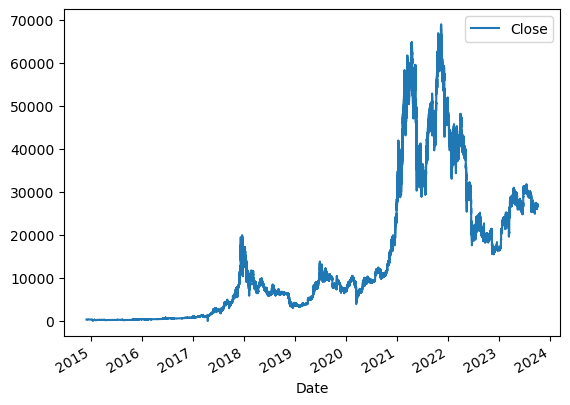

In [24]:
output_csv_df.plot(x="Date", y="Close")

In [25]:
#output final_df to csv
output_csv_df.to_csv(btc_csv, index=False)
print("1-minute Bitcoin csv file output!")

1-minute Bitcoin csv file output!
